# **Homework 3 - Convolutional Neural Network**

## Review
尝试了几次调参之后发现accuracy一直很低，所以记录一下调参过程

### 调参记录

#### 1. 前几次调参概述
- **配置**: 都做了data augmentation，使用supervised learning
- **网络结构**: 五层卷积层（做了bn）+ 两层全连接层（没做bn）
- **优化设置**: 优化器是adam，loss是cross entropy
- **训练过程**: 大概都train了40epoch左右early stop（10轮validation表现没有更好就stop），训练时间大概在1h
- **结果**: 在train set上的表现都会逐渐增大到80%左右，但是validation上的表现到50%就不再增加
- **问题分析**: 感觉是overfitting

#### 2. 新的第一次调整
- **调整内容**: 去掉了一层卷积层，并给fully_connected layer加了bn，dropout(0.2)
- **结果**: ![alt text](image.png)
- **问题分析**: train的时候不小心中断了一下，所以读了saving的model继续train的，共train52个epoch。表现仍然不好，validation上还是卡在50%。所以怀疑是不是数据量太小了，考虑使用semi-supervised learning，毕竟这也是这个作业的主线任务。

#### 3. 第二次调整
- **调整内容**: 添加semi-supervised，threshold=0.8。写完代码的时候一堆语法错误，主要包括想对分放在cpu和gpu上的数据进行运算，类型错误，返回空的dataset等问题，最后还是ai给改跑通了。
- **结果**: train上的表现在90%，validation的表现微微提高到近60%
- **问题分析**: semi-supervised的加入时机好像不太好，在train set上的accuracy只有30%左右的时候，就已经在把unlabeled的data添加进train set上了

#### 4. 第三次调整
- **调整内容**: 先train了一次supervised，accuracy为50%，然后用得到的model再开始semi-supervised
- **结果**: 和上一次的表现差不多
- **问题分析**: 难道是模型太差了，一直overfitting

### 5. 第四次调整
- **调整内容**: 使用了pytorch提供的resnet18，只使用supervised-learning，先后设置pre_trained=True和False
- **结果**：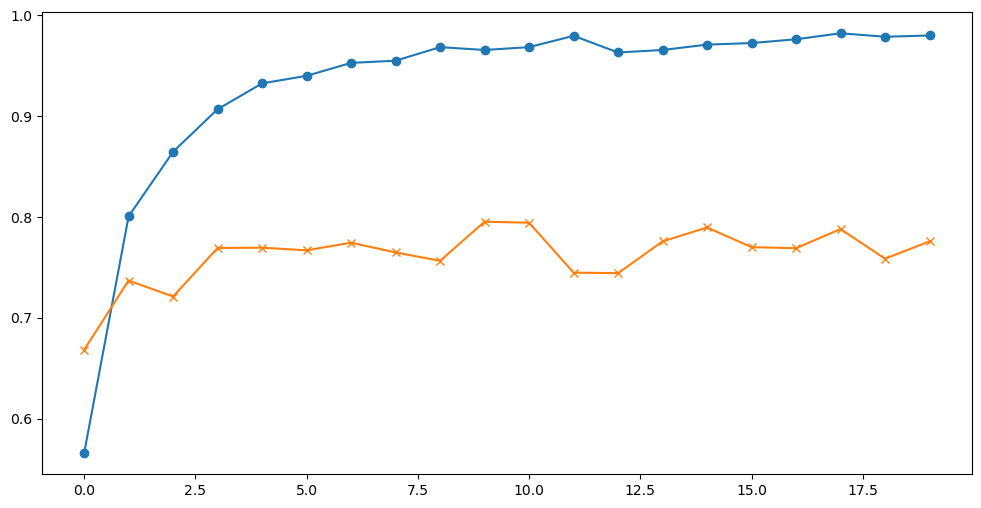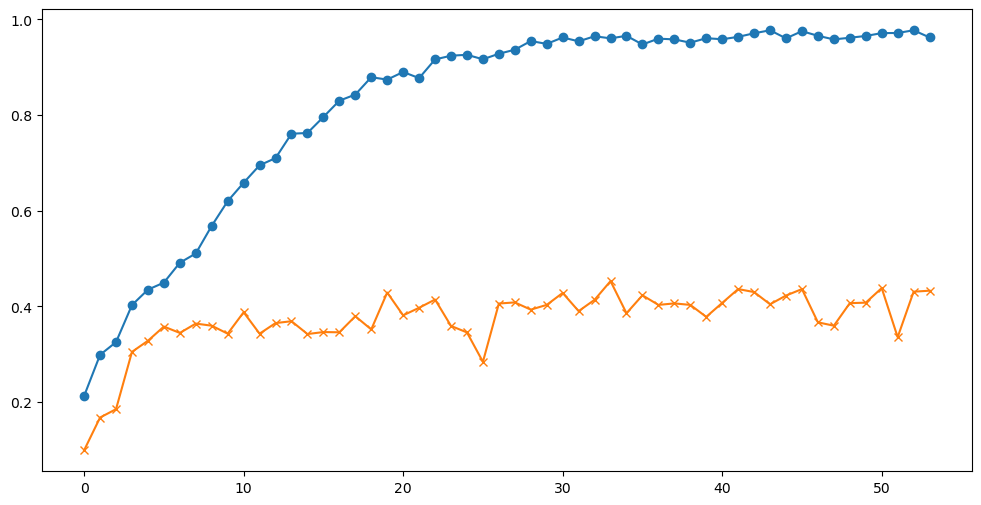
- **问题分析**：当pre_trained=True时，validation上的表现迎来了巨大的提升，而在pre_trained=False时，resnet18的表现甚至不如我们自己搭的model好。所以可见更大的数据集非常重要.

#### 6.第五次调整
- **调整内容**：采用了pre_trained=true且使用semi-supervised，threshold=0.8，只有在轮次能被5整除时添加伪标签
- **结果**：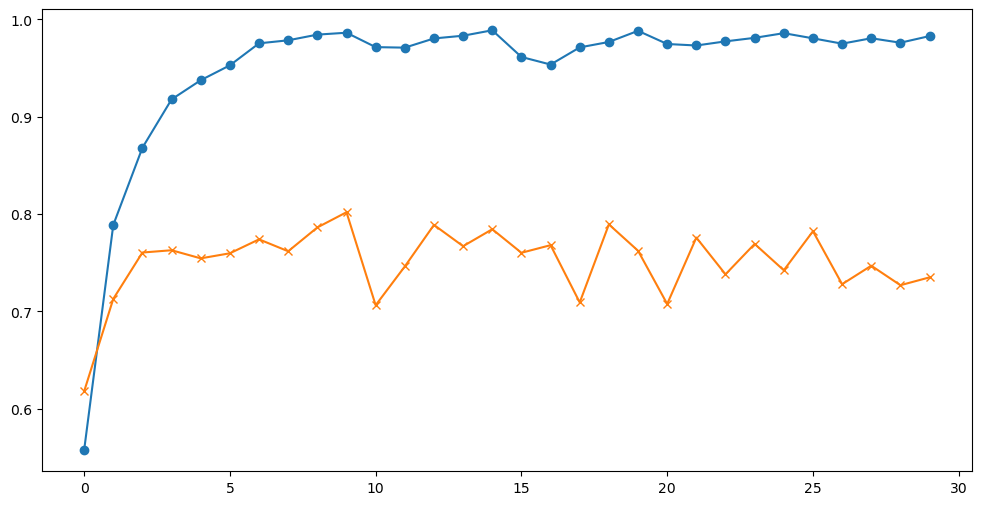
- **问题分析**：以为加入semi-supervised后能够更好，但是表现并没有提升，semi-supervised的策略应该是有问题的，混进去了错误的伪标签，同时early stop应该更宽松一些，因为伪标签的加入会造成accuracy震荡。

#### 总结：
- **1**原本认为overfitting的原因都是model的flexibility太大，应该调整模型就能解决。但是现在发现在数据量过小的情况下，model的表现很难很好
- **2**熟悉了更多的防止过拟合的方法，在这个程序中用到了l2正则化，dropout，增大model bias
- **3**semi-supervised要想train好有很多tips：我们使用的强制标记，应该设置较高的threshold；只有当model的表现比较好的时候（比如accuracy达到75%），才应该允许添加伪标签；每轮添加的伪标签应该限制数量；限制添加伪标签的轮次。尽管如此train完的结果仍然不是很好。下次希望尝试弹性标记，能够动态更新已经添加但是错误的伪标签。
- **4**其实从某种程度上我怀疑validation和train不是同分布的
- **5**在训练时间有限的情况下，使用pre-trained真的是非常好的方法


This is the example code of homework 3 of the machine learning course by Prof. Hung-yi Lee.

In this homework, you are required to build a convolutional neural network for image classification, possibly with some advanced training tips.


There are three levels here:

**Easy**: Build a simple convolutional neural network as the baseline. (2 pts)

**Medium**: Design a better architecture or adopt different data augmentations to improve the performance. (2 pts)

**Hard**: Utilize provided unlabeled data to obtain better results. (2 pts)

## **About the Dataset**

The dataset used here is food-11, a collection of food images in 11 classes.

For the requirement in the homework, TAs slightly modified the data.
Please DO NOT access the original fully-labeled training data or testing labels.

Also, the modified dataset is for this course only, and any further distribution or commercial use is forbidden.

In [ ]:
# Download the dataset
# You may choose where to download the data.

# Google Drive
!gdown --id '1awF7pZ9Dz7X1jn1_QAiKN-_v56veCEKy' --output food-11.zip

# Dropbox
# !wget https://www.dropbox.com/s/m9q6273jl3djall/food-11.zip -O food-11.zip

# MEGA
# !sudo apt install megatools
# !megadl "https://mega.nz/#!zt1TTIhK!ZuMbg5ZjGWzWX1I6nEUbfjMZgCmAgeqJlwDkqdIryfg"

# Unzip the dataset.
# This may take some time.
!unzip -q food-11.zip

## **Import Packages**

First, we need to import packages that will be used later.

In this homework, we highly rely on **torchvision**, a library of PyTorch.

In [ ]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

# This is for the progress bar.
from tqdm.auto import tqdm

from torch.utils.data import Dataset

## **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
# 在文件顶部定义加载函数
def pil_loader(path):
    return Image.open(path)

# 修改数据集构建
batch_size = 128

# Construct datasets.
train_set = DatasetFolder("food-11/training/labeled", loader=pil_loader, extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/validation", loader=pil_loader, extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/training/unlabeled", loader=pil_loader, extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/testing", loader=pil_loader, extensions="jpg", transform=test_tfm)

print(f"带标签的训练集大小: {len(train_set)}")
print(f"验证集大小: {len(valid_set)}")
print(f"无标签的数据集大小: {len(unlabeled_set)}")
print(f"测试集大小: {len(test_set)}")

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=False, num_workers=0)

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [ ]:

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
class PseudoDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __getitem__(self, index):
        return self.data[index], self.labels[index].item()
    def __len__(self):
        return len(self.data)
#semi-supervised learning的实现函数
def get_pseudo_labels(dataset, model, threshold=0.80):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    softmax = nn.Softmax(dim=-1)

    pseudo_data = []
    pseudo_labels = []
    # 存储被选中的样本在当前传入的 dataset 中的局部索引
    passed_indices_in_dataset = []

    # 使用 enumerate 来追踪批次号，用于计算索引
    for i, (img, _) in enumerate(tqdm(data_loader)):
        with torch.no_grad():
            logits = model(img.to(device))
        probs = softmax(logits)

        max_probs, pred_labels = torch.max(probs, dim=1)
        mask = max_probs > threshold
        
        pseudo_data.append(img[mask.cpu()])
        pseudo_labels.append(pred_labels[mask].cpu())

        batch_indices = torch.arange(len(mask))[mask.cpu()]

        for idx in batch_indices:
            passed_indices_in_dataset.append(i * batch_size + idx.item())
        
    model.train()

    if not pseudo_data or len(pseudo_data[0]) == 0:
        return PseudoDataset(torch.empty(0, 3, 128, 128), torch.empty(0)), []
    all_pseudo_data = torch.cat(pseudo_data, dim=0)
    all_pseudo_labels = torch.cat(pseudo_labels, dim=0)
    
    pseudo_dataset = PseudoDataset(all_pseudo_data, all_pseudo_labels)
    print(f"筛选出 {len(pseudo_dataset)} 个伪标签样本")

    # 如果传入的是 Subset，我们需要将局部索引映射回全局索引
    if isinstance(dataset, Subset):
        used_global_indices = [dataset.indices[i] for i in passed_indices_in_dataset]
    else: # 如果传入的是原始数据集
        used_global_indices = passed_indices_in_dataset
    
    return pseudo_dataset, used_global_indices

In [ ]:
# Initialize a model, and put it on the device specified.
import torchvision

model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 11)  # 修改最后一层以适应11类
model = model.to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

# The number of training epochs.
n_epochs = 100

# Whether to do semi-supervised learning.
do_semi = True

# 保存一份原始的、完整的无标签数据集的引用
original_unlabeled_set = unlabeled_set 
available_unlabeled_indices = list(range(len(original_unlabeled_set)))

early_stop_counter = 0
best_valid_acc = 0
train_acc=0
train_acc_list=[]
valid_acc_list=[]
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}")
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi and len(available_unlabeled_indices) > 0 and train_acc > 0.70 and epoch % 5 == 0:

        current_unlabeled_subset = Subset(original_unlabeled_set, available_unlabeled_indices)
        pseudo_set, used_indices = get_pseudo_labels(current_unlabeled_subset, model)
        used_indices_set = set(used_indices)
        available_unlabeled_indices = [idx for idx in available_unlabeled_indices if idx not in used_indices_set]
        
        print(f"剩余 {len(available_unlabeled_indices)} 个无标签样本用于下一轮")

        # Construct a new dataset and a data loader for training.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    else:
        print("无可用无标签数据，仅使用带标签数据进行训练。")

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_list.append(train_acc.item())
    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_acc_list.append(valid_acc.item())
    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        print(f"New best validation accuracy: {best_valid_acc:.5f}")
        torch.save(model.state_dict(), 'best_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= 20:
            print("Early stopping triggered.")
            break


In [ ]:
#plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_acc_list, label='Train Accuracy', marker='o')
plt.plot(valid_acc_list, label='Validation Accuracy', marker='x')

## **Testing**

For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

Last but not least, don't forget to save the predictions into a single CSV file.
The format of CSV file should follow the rules mentioned in the slides.

### **WARNING -- Keep in Mind**

Cheating includes but not limited to:
1.   using testing labels,
2.   submitting results to previous Kaggle competitions,
3.   sharing predictions with others,
4.   copying codes from any creatures on Earth,
5.   asking other people to do it for you.

Any violations bring you punishments from getting a discount on the final grade to failing the course.

It is your responsibility to check whether your code violates the rules.
When citing codes from the Internet, you should know what these codes exactly do.
You will **NOT** be tolerated if you break the rule and claim you don't know what these codes do.


In [ ]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

In [ ]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in  enumerate(predictions):
         f.write(f"{i},{pred}\n")